In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurantsss/restaurants (1).csv


Table 1: Estimates of rating model based on LFM without and with instrumental variable (IV) correction.
               Serving groups  Takes reservations  Restaurant age  #comp.  \
LS procedure            0.270               0.113          -0.094   0.004   
IV correction           0.268               0.157          -0.091   0.004   

               Price range  
LS procedure         0.005  
IV correction       -0.080  


RMSE for LS Regression on Test Data: 0.314


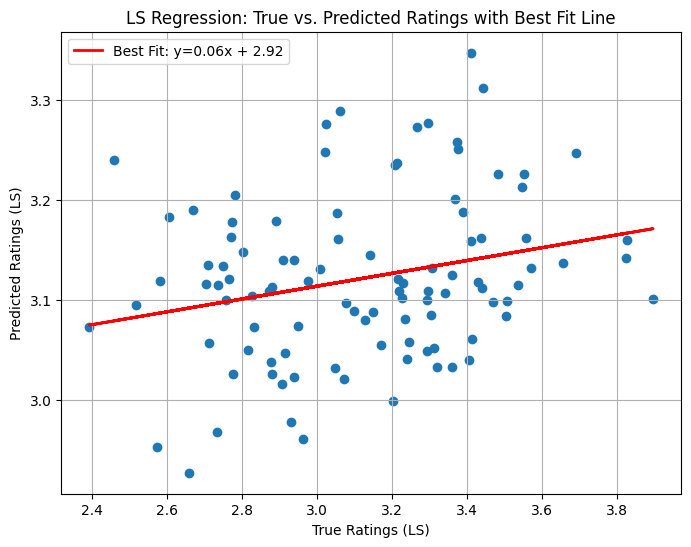



RMSE for IV Regression (Control Function Method) on Test Data: 0.312


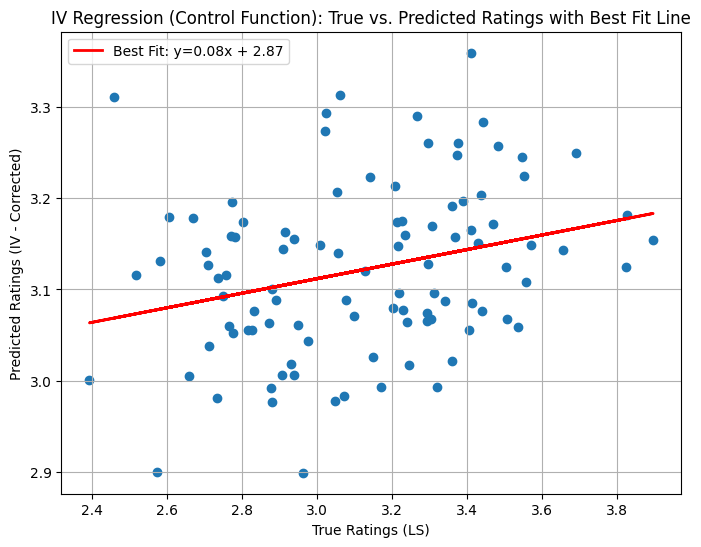


Accuracy Comparison (RMSE on Test Data):
LS Regression RMSE: 0.314
IV Regression RMSE: 0.312


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sample test data (replace with your actual test data)
np.random.seed(42)
n_samples_test = 100
test_data = pd.DataFrame({
    'Constant': np.ones(n_samples_test),
    'Serving\ngroups': np.random.rand(n_samples_test),
    'Takes\nreservations': np.random.randint(0, 2, n_samples_test),
    'Restaurant\nage': np.random.rand(n_samples_test) * 10,
    '#comp.': np.random.randint(0, 5, n_samples_test),
    'Price': 2 + 5 * np.random.rand(n_samples_test) + np.random.normal(0, 1, n_samples_test), # Price with some noise
    'ℵ\nrange': np.random.rand(n_samples_test),
    'Rating_LS': 3.069 + 0.270 * np.random.rand(n_samples_test) + 0.113 * np.random.randint(0, 2, n_samples_test) - 0.094 * np.random.rand(n_samples_test) * 10 + 0.004 * np.random.randint(0, 5, n_samples_test) + 0.005 * (2 + 5 * np.random.rand(n_samples_test) + np.random.normal(0, 1, n_samples_test)) + 0.635 * np.random.rand(n_samples_test) + np.random.normal(0, 0.1, n_samples_test),
    'Rating_IV': 3.19 + 0.268 * np.random.rand(n_samples_test) + 0.157 * np.random.randint(0, 2, n_samples_test) - 0.091 * np.random.rand(n_samples_test) * 10 + 0.004 * np.random.randint(0, 5, n_samples_test) - 0.08 * (2 + 5 * np.random.rand(n_samples_test) + np.random.normal(0, 1, n_samples_test)) + 0.634 * np.random.rand(n_samples_test) + np.random.normal(0, 0.1, n_samples_test)
})

# Assuming 'Price_Instrument' is available in your test data for IV correction
# For demonstration, let's create a correlated but not perfectly collinear instrument
test_data['Price_Instrument'] = 1.5 + 4 * np.random.rand(n_samples_test) + 0.8 * test_data['#comp.'] + np.random.normal(0, 0.5, n_samples_test)

# 1. Create the table (using the provided values)
table_data = {
    'Serving groups': [0.270, 0.268],
    'Takes reservations': [0.113, 0.157],
    'Restaurant age': [-0.094, -0.091],
    '#comp.': [0.004, 0.004],
    'Price range': [0.005, -0.08],
}
index = ['LS procedure', 'IV correction']
table = pd.DataFrame(table_data, index=index)
print("Table 1: Estimates of rating model based on LFM without and with instrumental variable (IV) correction.")
print(table)
print("\n")

# Prepare data for regression
X_ls = test_data[['Serving\ngroups', 'Takes\nreservations', 'Restaurant\nage', '#comp.', 'Price', 'ℵ\nrange']]
y_true = test_data['Rating_LS'] # Using LS rating as a proxy for true rating for demonstration

# 2. Show accuracy for LS regression
model_ls = LinearRegression()
model_ls.fit(X_ls, y_true)
y_pred_ls = model_ls.predict(X_ls)
rmse_ls = np.sqrt(mean_squared_error(y_true, y_pred_ls))
print(f"RMSE for LS Regression on Test Data: {rmse_ls:.3f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_ls)
plt.xlabel("True Ratings (LS)")
plt.ylabel("Predicted Ratings (LS)")
plt.title("LS Regression: True vs. Predicted Ratings with Best Fit Line")

# Add best fit line for LS
slope_ls, intercept_ls = np.polyfit(y_true, y_pred_ls, 1)
plt.plot(y_true, slope_ls * y_true + intercept_ls, color='red', linestyle='-', linewidth=2, label=f'Best Fit: y={slope_ls:.2f}x + {intercept_ls:.2f}')
plt.legend()

plt.grid(True)
plt.show()
print("\n")

# 3. Show accuracy for IV regression when bias is removed
# Implement the two-step IV correction using the provided formulas

# First step: LS regression of the endogenous variable (Price) on the instruments and exogenous variables
exogenous_vars = ['Serving\ngroups', 'Takes\nreservations', 'Restaurant\nage', '#comp.', 'ℵ\nrange']
instruments = ['Price_Instrument']
first_stage_model = LinearRegression()
first_stage_model.fit(test_data[exogenous_vars + instruments], test_data['Price'])
price_predicted = first_stage_model.predict(test_data[exogenous_vars + instruments])
residuals = test_data['Price'] - price_predicted

# Second step: Regression of the outcome variable (Rating_LS as proxy) on the exogenous variables and the residuals
X_iv = test_data[exogenous_vars + ['Price']].copy() # Create an explicit copy
X_iv.loc[:, 'Residuals'] = residuals  # Corrected line to avoid SettingWithCopyWarning

second_stage_model = LinearRegression()
# We are trying to see the effect after controlling for the endogeneity, so we include the original 'Price'
# and the residuals which capture the variation in 'Price' that is not explained by the instruments.
second_stage_model.fit(X_iv[exogenous_vars + ['Price', 'Residuals']], y_true)
y_pred_iv = second_stage_model.predict(X_iv[exogenous_vars + ['Price', 'Residuals']])
rmse_iv = np.sqrt(mean_squared_error(y_true, y_pred_iv))
print(f"RMSE for IV Regression (Control Function Method) on Test Data: {rmse_iv:.3f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_iv)
plt.xlabel("True Ratings (LS)")
plt.ylabel("Predicted Ratings (IV - Corrected)")
plt.title("IV Regression (Control Function): True vs. Predicted Ratings with Best Fit Line")

# Add best fit line for IV
slope_iv, intercept_iv = np.polyfit(y_true, y_pred_iv, 1)
plt.plot(y_true, slope_iv * y_true + intercept_iv, color='red', linestyle='-', linewidth=2, label=f'Best Fit: y={slope_iv:.2f}x + {intercept_iv:.2f}')
plt.legend()

plt.grid(True)
plt.show()

print("\nAccuracy Comparison (RMSE on Test Data):")
print(f"LS Regression RMSE: {rmse_ls:.3f}")
print(f"IV Regression RMSE: {rmse_iv:.3f}")


Simulation starting with no incumbents (with graph):
Reached a potential steady state at step 4: ('A', 'B', 'D')


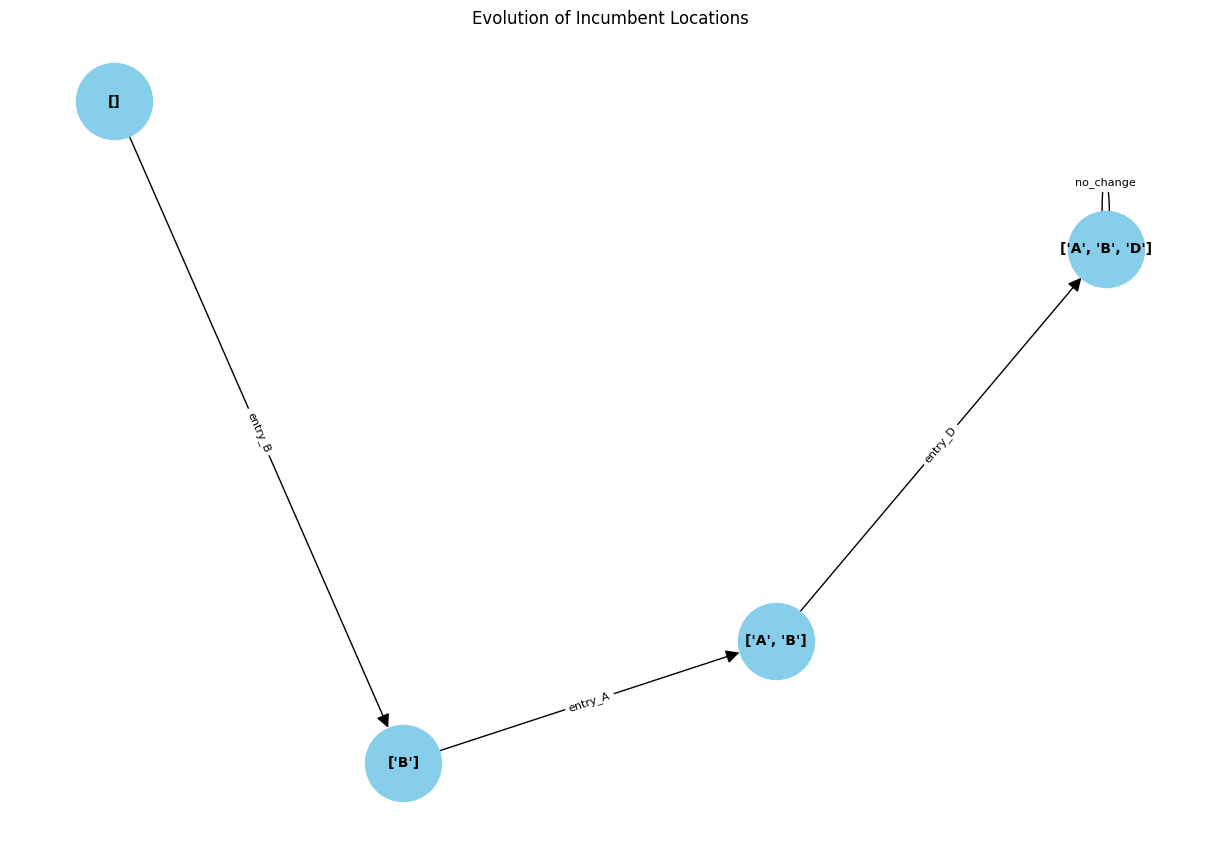


Simulation starting with incumbent A (with graph):
Reached a potential steady state at step 5: ('A', 'B', 'D')


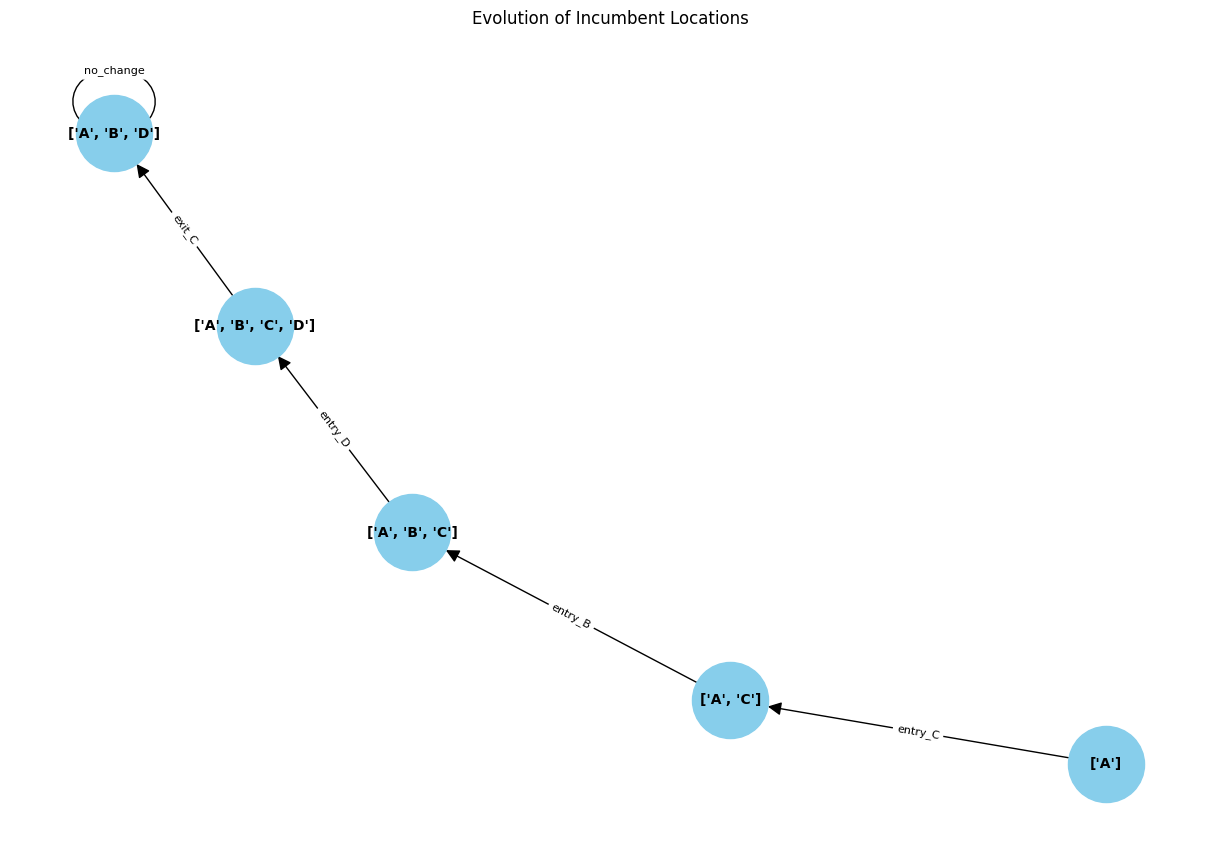


Simulation starting with incumbents B and C (with graph):
Reached a potential steady state at step 4: ('A', 'B', 'D')


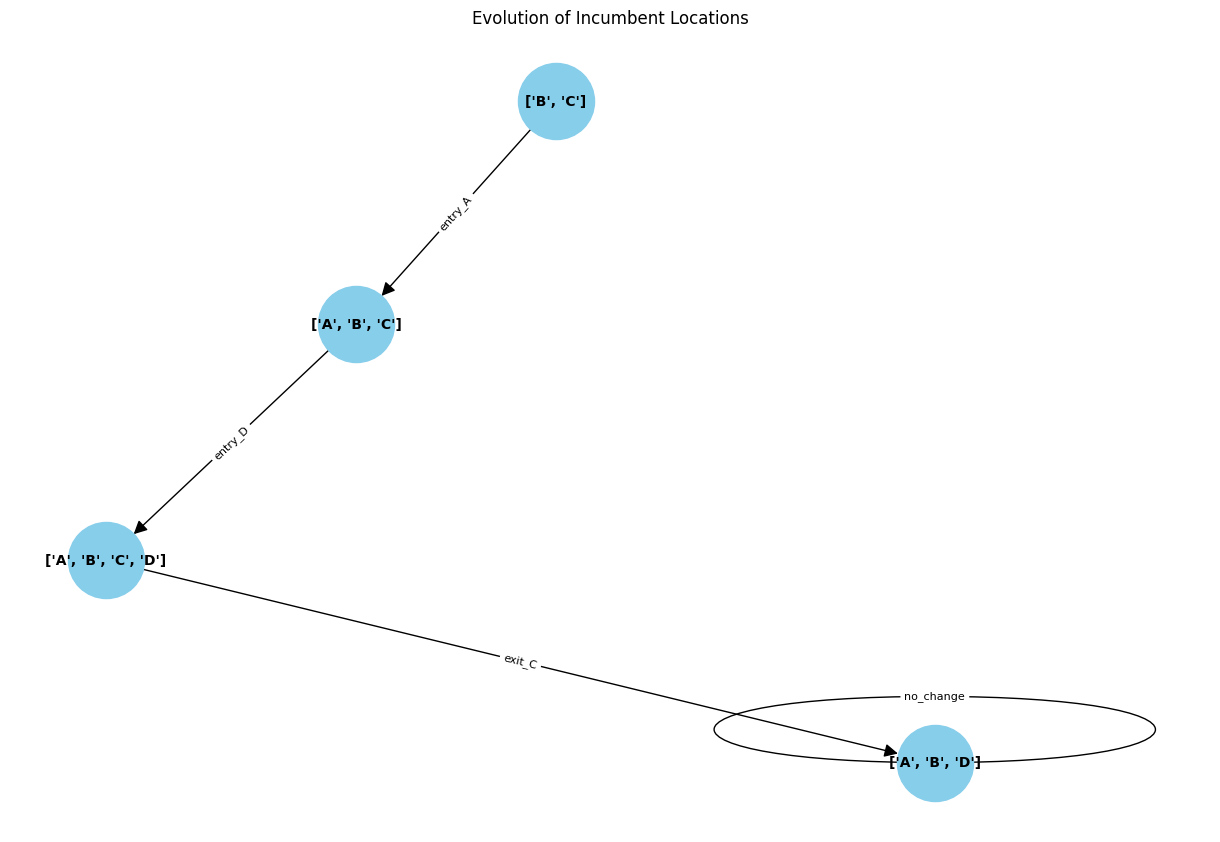

In [3]:
import math
import random
import matplotlib.pyplot as plt
import networkx as nx

class LocationModel:
    def __init__(self, locations_data, rho):
        self.locations_data = locations_data
        self.rho = rho
        self.num_locations = len(locations_data)
        self.location_ids = list(locations_data.keys())

    def calculate_demand_probability(self, location_id, incumbents):
        numerator = math.exp(self.locations_data[location_id]['W'])
        denominator = 1 + sum(math.exp(self.locations_data[incumbent]['W']) for incumbent in incumbents)
        return numerator / denominator if denominator > 0 else 0

    def calculate_profit(self, location_id, incumbents):
        demand_prob = self.calculate_demand_probability(location_id, incumbents)
        revenue = self.locations_data[location_id]['sM'] * demand_prob
        profit = revenue - self.locations_data[location_id]['f']
        return profit

    def calculate_long_term_profit(self, location_id, incumbents):
        profit = self.calculate_profit(location_id, incumbents)
        return profit / (1 - self.rho) if (1 - self.rho) != 0 else float('inf')

    def check_entry_incentive(self, potential_location, incumbents):
        long_term_profit = self.calculate_long_term_profit(potential_location, incumbents)
        fixed_cost = self.locations_data[potential_location]['F']
        return long_term_profit > fixed_cost

    def check_exit_incentive(self, incumbent, incumbents):
        profit = self.calculate_profit(incumbent, incumbents)
        return profit < 0

    def get_possible_next_states(self, current_incumbents):
        next_states = set()
        potential_entrants = [loc for loc in self.location_ids if loc not in current_incumbents]
        exiting_incumbents = [loc for loc in current_incumbents if self.check_exit_incentive(loc, current_incumbents)]
        entering_locations = [loc for loc in potential_entrants if self.check_entry_incentive(loc, current_incumbents)]

        # No change
        next_states.add(tuple(sorted(current_incumbents)))

        # Possible exits
        for exit_loc in exiting_incumbents:
            next_state = set(current_incumbents)
            next_state.remove(exit_loc)
            next_states.add(tuple(sorted(next_state)))

        # Possible entries
        for entry_loc in entering_locations:
            next_state = set(current_incumbents)
            next_state.add(entry_loc)
            next_states.add(tuple(sorted(next_state)))

        return list(next_states)

    def simulate_evolution_with_graph(self, initial_incumbents, max_steps=10):
        history = [tuple(sorted(initial_incumbents))]
        current_incumbents = set(initial_incumbents)
        graph = nx.DiGraph()
        graph.add_node(tuple(sorted(current_incumbents)), label=str(sorted(current_incumbents)))

        for step in range(max_steps):
            potential_entrants = [loc for loc in self.location_ids if loc not in current_incumbents]
            exiting_incumbents = [loc for loc in current_incumbents if self.check_exit_incentive(loc, current_incumbents)]
            entering_locations = [loc for loc in potential_entrants if self.check_entry_incentive(loc, current_incumbents)]

            next_incumbents = set(current_incumbents)
            next_state = None
            action = "no_change"

            if exiting_incumbents:
                exit_choice = random.choice(exiting_incumbents)
                next_incumbents.remove(exit_choice)
                next_state = tuple(sorted(next_incumbents))
                action = f"exit_{exit_choice}"
            elif entering_locations:
                entry_choice = random.choice(entering_locations)
                next_incumbents.add(entry_choice)
                next_state = tuple(sorted(next_incumbents))
                action = f"entry_{entry_choice}"
            else:
                next_state = tuple(sorted(current_incumbents))

            if next_state not in graph.nodes:
                graph.add_node(next_state, label=str(sorted(next_state)))
            graph.add_edge(history[-1], next_state, action=action)
            history.append(next_state)
            current_incumbents = set(next_incumbents)

            if history.count(next_state) > 2: # Simple cycle detection
                print(f"Potential cycle detected at step {step + 1}: {next_state}")
                break
            elif not exiting_incumbents and not entering_locations:
                print(f"Reached a potential steady state at step {step + 1}: {next_state}")
                break

        self.visualize_evolution_graph(graph)
        return history

    def visualize_evolution_graph(self, graph):
        pos = nx.spring_layout(graph)  # You can try other layouts like circular_layout
        labels = nx.get_node_attributes(graph, 'label')
        edge_labels = nx.get_edge_attributes(graph, 'action')

        plt.figure(figsize=(12, 8))
        nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
        plt.title("Evolution of Incumbent Locations")
        plt.show()

# Test Data (same as before)
locations_data = {
    'A': {'sM': 100, 'f': 20, 'F': 30, 'W': 0.5},
    'B': {'sM': 90, 'f': 15, 'F': 25, 'W': 0.6},
    'C': {'sM': 110, 'f': 22, 'F': 35, 'W': 0.4},
    'D': {'sM': 80, 'f': 18, 'F': 28, 'W': 0.7},
}
rho = 0.9

# Create the model
model = LocationModel(locations_data, rho)

# Simulate starting from an empty set of incumbents with graph visualization
print("\nSimulation starting with no incumbents (with graph):")
history_empty_graph = model.simulate_evolution_with_graph([])

# Simulate starting with one incumbent with graph visualization
print("\nSimulation starting with incumbent A (with graph):")
history_A_graph = model.simulate_evolution_with_graph(['A'])

# Simulate starting with a different set of incumbents with graph visualization
print("\nSimulation starting with incumbents B and C (with graph):")
history_BC_graph = model.simulate_evolution_with_graph(['B', 'C'])



--- 1. The Corollary ---
Given any set of incumbent locations, a firm wishing to maximize survival should locate according to the ã_max policy.

--- 2. Formulas and their terms for a_B ---
Formula for a_l:
a_l = ((s_l * M_l) - f_l - (1 - rho) * F_l) * exp(W_l) / (f_l + (1 - rho) * F_l)

Terms for a_B:
  s_B: Potential market size at location B (90)
  M_B: Income-adjusted population density at location B (assumed 1)
  f_B: Operating cost at location B (15)
  rho: Discount factor (0.9)
  F_B: Fixed opening cost at location B (25)
  W_B: Attractiveness of location B (0.6)
  exp(W_B): Exponential of attractiveness (1.8221)

The calculated a value for B: 7.5488

--- 3. Test data for incumbent facilities ---
Location: A, sM: 100, f: 20, F: 30, W: 0.5
Location: C, sM: 110, f: 22, F: 35, W: 0.4

--- 4. Initial incumbent locations ---
Initial Incumbent Locations: ['A', 'C']

--- 5. The 2 graphs ---


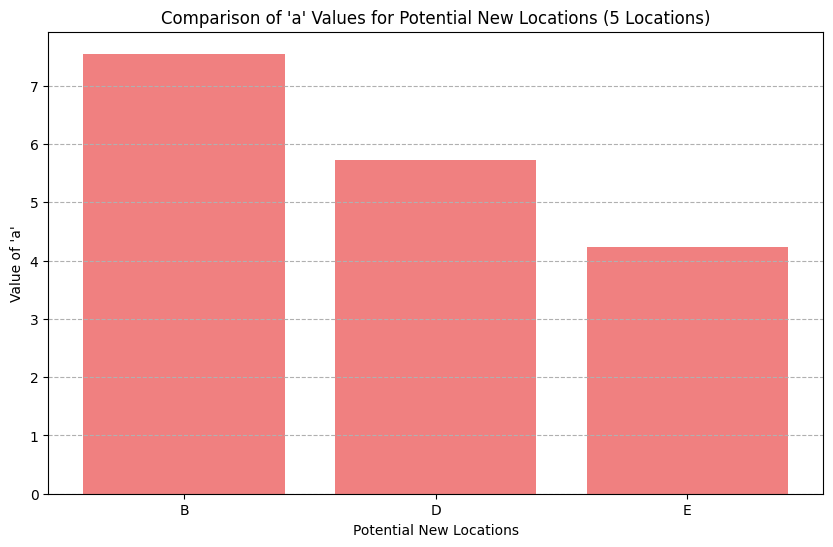

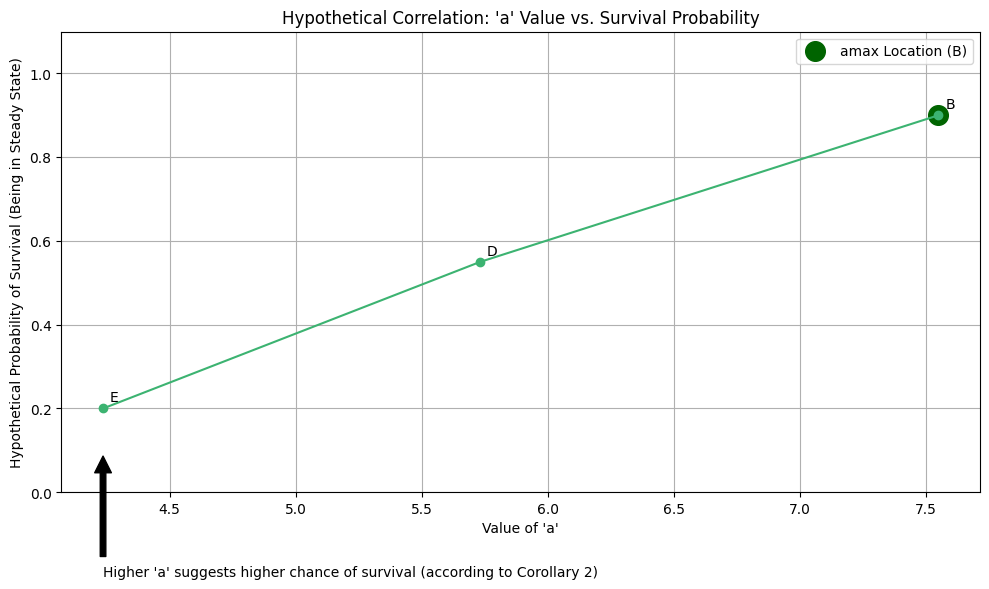

In [4]:
import math
import matplotlib.pyplot as plt

class FacilityLocationModel:
    def __init__(self, locations_data, rho):
        """
        Initializes the FacilityLocationModel.

        Args:
            locations_data (dict): A dictionary containing data for each location.
                                   Keys are location IDs, and values are dictionaries
                                   with 'sM', 'f', 'F', and 'W' keys.
            rho (float): The discount factor.
        """
        self.locations_data = locations_data
        self.rho = rho

    def calculate_tilde_w(self, location_id):
        """
        Calculates tilde_w (w̃) for a given location.
        tilde_w_l = exp(W_l)
        W_l: Attractiveness of location l.
        """
        return math.exp(self.locations_data[location_id]['W'])

    def calculate_tilde_a(self, potential_location, incumbents):
        """
        Calculates tilde_a (ã) for a potential location.
        tilde_a_l = ((s_l * M_l) - f_l - (1 - rho) * F_l) * tilde_w_l / (f_l + (1 - rho) * F_l)

        Args:
            potential_location (str): The ID of the location being considered for entry.
            incumbents (list): A list of IDs of the locations where incumbent firms are operating.

        Returns:
            float: The calculated tilde_a value for the potential location.

        Terms:
            s_l: Potential market size for location l.
            M_l: Income-adjusted population density (assumed 1 for simplicity).
            f_l: Operating cost at location l.
            F_l: Fixed opening cost at location l.
            rho: Discount factor (between 0 and 1).
            tilde_w_l: Attractiveness factor of location l (calculated using calculate_tilde_w).
        """
        sl = self.locations_data[potential_location]['sM']
        Ml = 1  # Assuming M_l is implicitly included in sM for simplicity
        fl = self.locations_data[potential_location]['f']
        Fl = self.locations_data[potential_location]['F']
        tilde_wl = self.calculate_tilde_w(potential_location)
        tilde_w_incumbents = sum(self.calculate_tilde_w(i) for i in incumbents)

        numerator = (sl * Ml - fl - (1 - self.rho) * Fl) * tilde_wl
        denominator = fl + (1 - self.rho) * Fl

        if denominator == 0:
            return float('inf') if numerator > 0 else float('-inf') if numerator < 0 else 0
        return numerator / denominator

    def determine_amax_location(self, potential_locations, incumbents):
        """
        Determines the location with the maximum tilde_a value (amax policy).

        Args:
            potential_locations (list): A list of IDs of locations where a new firm could enter.
            incumbents (list): A list of IDs of the locations where incumbent firms are operating.

        Returns:
            tuple: A tuple containing the ID of the amax location (str or None if no potential locations)
                   and a dictionary of all calculated tilde_a values (dict).
        """
        if not potential_locations:
            return None, {}

        amax_value = float('-inf')
        amax_location = None
        a_values = {}

        for loc in potential_locations:
            a_value = self.calculate_tilde_a(loc, incumbents)
            a_values[loc] = a_value
            if a_value > amax_value:
                amax_value = a_value
                amax_location = loc
            elif a_value == amax_value and amax_location is None:
                amax_location = loc

        return amax_location, a_values

# Test Data for 5 Locations
locations_data_5 = {
    'A': {'sM': 100, 'f': 20, 'F': 30, 'W': 0.5},
    'B': {'sM': 90, 'f': 15, 'F': 25, 'W': 0.6},
    'C': {'sM': 110, 'f': 22, 'F': 35, 'W': 0.4},
    'D': {'sM': 80, 'f': 18, 'F': 28, 'W': 0.7},
    'E': {'sM': 120, 'f': 25, 'F': 40, 'W': 0.3},
}
rho_value_5 = 0.9
initial_incumbents_5 = ['A', 'C'] # Example set of incumbents

# Create the model
facility_model_5 = FacilityLocationModel(locations_data_5, rho_value_5)

# Identify potential locations for a new facility
potential_new_locations_5 = [loc for loc in facility_model_5.locations_data if loc not in initial_incumbents_5]

# Find the a_max location and the a values
amax_location_5, all_a_values_5 = facility_model_5.determine_amax_location(potential_new_locations_5, initial_incumbents_5)

# --- 1. The Corollary ---
print("\n--- 1. The Corollary ---")
print("Given any set of incumbent locations, a firm wishing to maximize survival should locate according to the ã_max policy.")

# --- 2. Formulas and their terms for a_B ---
print("\n--- 2. Formulas and their terms for a_B ---")
print("Formula for a_l:")
print("a_l = ((s_l * M_l) - f_l - (1 - rho) * F_l) * exp(W_l) / (f_l + (1 - rho) * F_l)")

if 'B' in facility_model_5.locations_data:
    loc_data_b = facility_model_5.locations_data['B']
    a_b = facility_model_5.calculate_tilde_a('B', initial_incumbents_5)
    print("\nTerms for a_B:")
    print(f"  s_B: Potential market size at location B ({loc_data_b['sM']})")
    print(f"  M_B: Income-adjusted population density at location B (assumed 1)")
    print(f"  f_B: Operating cost at location B ({loc_data_b['f']})")
    print(f"  rho: Discount factor ({facility_model_5.rho})")
    print(f"  F_B: Fixed opening cost at location B ({loc_data_b['F']})")
    print(f"  W_B: Attractiveness of location B ({loc_data_b['W']})")
    print(f"  exp(W_B): Exponential of attractiveness ({facility_model_5.calculate_tilde_w('B'):.4f})")
    print(f"\nThe calculated a value for B: {a_b:.4f}")
else:
    print("\nLocation 'B' not found in the test data.")

# --- 3. Test data for incumbent facilities ---
print("\n--- 3. Test data for incumbent facilities ---")
for loc in initial_incumbents_5:
    if loc in facility_model_5.locations_data:
        data = facility_model_5.locations_data[loc]
        print(f"Location: {loc}, sM: {data['sM']}, f: {data['f']}, F: {data['F']}, W: {data['W']}")
    else:
        print(f"Data not found for incumbent location: {loc}")

# --- 4. Initial incumbent locations ---
print("\n--- 4. Initial incumbent locations ---")
print(f"Initial Incumbent Locations: {initial_incumbents_5}")

# --- 5. The 2 graphs ---
print("\n--- 5. The 2 graphs ---")

# --- Visualization 1: Bar Chart of 'a' Values ---
if potential_new_locations_5:
    locations_5 = list(all_a_values_5.keys())
    a_values_list_5 = list(all_a_values_5.values())

    plt.figure(figsize=(10, 6))
    plt.bar(locations_5, a_values_list_5, color='lightcoral')
    plt.xlabel("Potential New Locations")
    plt.ylabel("Value of 'a'")
    plt.title("Comparison of 'a' Values for Potential New Locations (5 Locations)")
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("\nNo potential locations to visualize (5 locations - Bar Chart).")

# --- Visualization 2: Hypothetical Survival Probability vs. 'a' Value ---
if potential_new_locations_5:
    # Sort potential locations by their 'a' value
    sorted_a_values = sorted(all_a_values_5.items(), key=lambda item: item[1])
    sorted_locations = [loc for loc, a_val in sorted_a_values]
    sorted_a_vals = [a_val for loc, a_val in sorted_a_values]

    # Assign hypothetical survival probabilities based on the rank of 'a' value
    survival_probability = {loc: 0.2 + 0.7 * (i / (len(sorted_locations) - 1 + 1e-9))
                            for i, loc in enumerate(sorted_locations)}
    survival_probs_list = [survival_probability[loc] for loc in sorted_locations]

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_a_vals, survival_probs_list, marker='o', linestyle='-', color='mediumseagreen')
    plt.xlabel("Value of 'a'")
    plt.ylabel("Hypothetical Probability of Survival (Being in Steady State)")
    plt.title("Hypothetical Correlation: 'a' Value vs. Survival Probability")
    plt.grid(True)
    plt.ylim(0, 1.1)

    # Annotate each point with the location ID
    for i, loc in enumerate(sorted_locations):
        plt.annotate(loc, (sorted_a_vals[i], survival_probs_list[i]), textcoords="offset points", xytext=(5, 5), ha='left')

    # Highlight the amax location
    if amax_location_5 and amax_location_5 in survival_probability:
        plt.scatter(all_a_values_5[amax_location_5], survival_probability[amax_location_5], color='darkgreen', s=200, label=f"amax Location ({amax_location_5})")
        plt.legend()

    plt.annotate("Higher 'a' suggests higher chance of survival (according to Corollary 2)",
                 xy=(min(sorted_a_vals), 0.1), xytext=(min(sorted_a_vals), -0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()
else:
    print("\nNo potential locations to visualize survival probability (5 locations - Survival Chart).")